In [1]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# lista_ativos = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'WEGE3.SA',
#        'B3SA3.SA', 'BBAS3.SA', 'RENT3.SA', 'PRIO3.SA', 'SUZB3.SA', 'GGBR4.SA',
#        'CSNA3.SA', 'GOAU4.SA', 'RADL3.SA', 'ENEV3.SA', 'EQTL3.SA', 'FLRY3.SA',
#        'HAPV3.SA', 'MGLU3.SA', '^BVSP']

lista_ativos = [
    'VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'BBDC4.SA', 
    'BBAS3.SA', 'ABEV3.SA', 'B3SA3.SA', 'ITSA4.SA', 
    'WEGE3.SA', 'RENT3.SA',  'LREN3.SA', 'GGBR4.SA', 
    'MGLU3.SA', 'RADL3.SA', 'VIVT3.SA', 'BBSE3.SA', 'BPAC11.SA', 
    'EQTL3.SA', 'CSAN3.SA',  'RAIL3.SA', 
     'HAPV3.SA', 'RDOR3.SA',  'CMIG4.SA', 
    'SBSP3.SA',  'PRIO3.SA', 'EGIE3.SA', 
    'KLBN11.SA', 'TOTS3.SA', 'CPFE3.SA', 'CYRE3.SA', 'CSNA3.SA', 
    'GOAU4.SA', 'USIM5.SA', 'BRAP4.SA', 'MRVE3.SA', 'MULT3.SA', 
    'BEEF3.SA', 'YDUQ3.SA', 'COGN3.SA', 'AZUL4.SA'
]

# lista_ativos = random.sample(lista_ativos,20)

print("-----------COMEÇANDO---------")


#DADOS DOS ATIVOS
mydf = pd.DataFrame()
for ativo in lista_ativos:
    mydf[ativo] = yf.download(ativo, period="1y")["Close"]



retornos_ativos = (mydf / mydf.shift(1))-1



#DADOS DO IBOV
mydf_ibov = pd.DataFrame()
mydf_ibov['IBOV'] = yf.download('^BVSP', period="1y")["Close"]


retorno_ibov = (mydf_ibov / mydf_ibov.shift(1)) - 1



#--------------- MANUS CONSERTANDO
# DICA: Remova os NaNs que o shift(1) cria na primeira linha
retornos_ativos = retornos_ativos.dropna()
retorno_ibov = retorno_ibov.dropna()

# Alinhando os dados para garantir que tenham o mesmo número de linhas
common_index = retornos_ativos.index.intersection(retorno_ibov.index)
retornos_ativos = retornos_ativos.loc[common_index]
retorno_ibov = retorno_ibov.loc[common_index]

In [ ]:
#--------------------------- MODELO
model = pyo.ConcreteModel()

## Sempre preciso definir os conjuntos SETS
# A é para os ativos, quantidade de ativos
# T é para a quantidade de linhas, de dias
model.A = pyo.RangeSet(0,len(retornos_ativos.columns)-1 )
model.T = pyo.RangeSet(0, len(retornos_ativos)-1)

## OS DATAFRAMES PRECISAM SER PARAMETROS (PARAMS) {(index):value}
retornos_dict = {}
for t in range(len(retornos_ativos)):
    for a in range(len(retornos_ativos.columns)):
        retornos_dict[t, a] = retornos_ativos.iloc[t, a]

retornos_ibov_dict = {}
for s in range(len(retorno_ibov['IBOV'])):
    retornos_ibov_dict[s] = retorno_ibov['IBOV'].iloc[s]

## DEFININDO OS PARAMETROS
model.R = pyo.Param(model.T, model.A, initialize=retornos_dict)
model.R_IBOV = pyo.Param(model.T, initialize=retornos_ibov_dict)


## Definindo as variáveis
model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)

## Função Objetivo
def func_objetivo(model):
    return sum(
        (sum(model.R[t,a]*model.x[a] for a in model.A)-model.R_IBOV[t])**2 for t in model.T
    )
model.obj = pyo.Objective(rule=func_objetivo, sense = pyo.minimize)

# Restrições

#DICA
# #1. Regra Indexada: def regra(model, a):
# O que significa: "Aplique esta regra para cada elemento do conjunto a".
# No seu caso: A restrição de vínculo ($x_a \le y_a$) precisa ser verificada para a PETR4, depois para a VALE3, depois para a ITUB4... individualmente.
# Resultado: Se você tem 41 ativos, o Pyomo criará 41 restrições separadas na memória.
# 2. Regra Global: def regra(model):
# O que significa: "Aplique esta regra uma única vez para o modelo inteiro".
# No seu caso: A soma de todos os pesos deve ser 1. Você não quer que cada ativo individualmente some 1, você quer que a carteira toda some 1.
# Resultado: O Pyomo criará apenas 1 restrição na memória.

#Restrição de vinculo, x só existe se y = 1
def func_vinc_x_y(model, a):
    return model.x[a] <= model.y[a]
model.vinc_x_y = pyo.Constraint(model.A, rule=func_vinc_x_y)

#Restrição de soma (soma dos pesos tem que ser igual a 1)
def func_soma_peso_1(model):
    return sum(model.x[a] for a in model.A ) ==1
model.soma_peso_1 = pyo.Constraint(rule=func_soma_peso_1)

#Restrição de cardinalidade (quantidade de ativos na carteira)
def func_cardinalidade(model):
    return sum(model.y[a] for a in model.A) <= 15
model.cardinalidade = pyo.Constraint(rule=func_cardinalidade)

opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
resultado = opt.solve(model)


print("-------FIM----------")
# model.pprint()

lsita_grande = []
for numero in range(len(retornos_ativos.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativos.columns)
print(final[final['ativado']==1])

In [216]:
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativos[ativos_selecionados]

carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi

C:\Users\joaon\AppData\Local\Temp\ipykernel_4540\1590415795.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\joaon\AppData\Local\Temp\ipykernel_4540\1590415795.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\joaon\AppData\Local\Temp\ipykernel_4540\1590415795.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


126.60408119807467
125.82380390650714
125.35788752995343


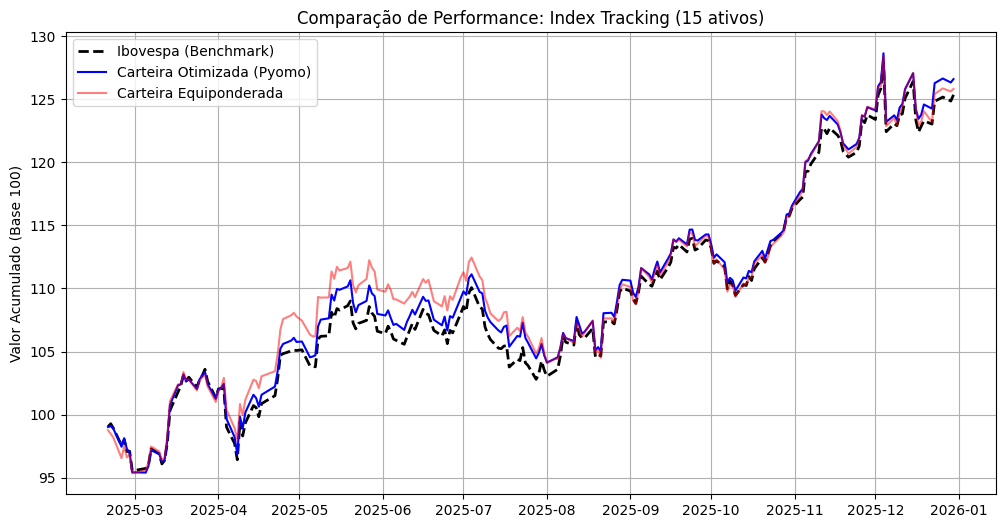

In [228]:
# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retorno_ibov['IBOV']).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

# 4. Plotar o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(acum_ibov, label='Ibovespa (Benchmark)', color='black', linewidth=2, linestyle='--')
plt.plot(acum_otimizado, label='Carteira Otimizada (Pyomo)', color='blue')
plt.plot(acum_equi, label='Carteira Equiponderada', color='red', alpha=0.5)

plt.title('Comparação de Performance: Index Tracking (15 ativos)')
plt.ylabel('Valor Acumulado (Base 100)')
plt.legend()
plt.grid(True)
plt.show()